In [54]:
import pandas as pd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import numpy.ma as ma
import matplotlib.dates as mdates
%matplotlib inline
%config inlinebackend.figure_format='retina'

# Remake Fig. 4 from Gordon et al. (2020)

https://doi.org/10.1029/2020GL087014

Extend Fig. 4 time series of Nino 3.4, Southern Annular Mode (SAM), and wind stress curl anomaly over the Weddell Sea (30°W–30°E, 60–70°S) to present.


# Retrieve Nino 3.4 from NOAA

In [44]:
### Nino 3.4 data

url = 'https://psl.noaa.gov/data/correlation/nina34.data'

df = pd.read_csv(url, delim_whitespace=True, skiprows=1, header=None,index_col=0)

# Rename Index.
df = df.rename_axis('Year')

# Convert the 'Year' column to numeric values
df.index = pd.to_numeric(df.index, errors='coerce')

# Remove the rows that contain NaN values
df = df.dropna()



# Convert all columns to floats
df = df.astype(float)

# Replace the fill_value (-99.99) with np.nan
df = df.replace(-99.99, np.nan)

# Convert the index column to integers
df.index = df.index.astype(int)



### Convert dataframe to an xarray dataset with datetime objects as dimension
years = np.asarray(df.index)
months = np.asarray(df.columns)
datetimes = np.array([np.datetime64(f"{year}-{month:02d}") for year in years for month in months])
nino_data = np.ravel(np.asarray(df))
ds_nino = xr.Dataset(
                     {"nino":(["time"],nino_data,)},
                     coords={"time": datetimes},
                    ) 

# Retrieve SAM data from British Antarctic Survey (BAS)

In [45]:
### SAM

url = 'http://www.nerc-bas.ac.uk/public/icd/gjma/newsam.1957.2007.txt'

df = pd.read_csv(url, delim_whitespace=True, skiprows=1, header=None,index_col=0)

# Rename Index.
df = df.rename_axis('Year')

# Convert the 'Year' column to numeric values
df.index = pd.to_numeric(df.index, errors='coerce')

# Convert all columns to floats
df = df.astype(float)

# Convert the index column to integers
df.index = df.index.astype(int)

### Convert dataframe to an xarray dataset with datetime objects as dimension
years = np.asarray(df.index)
months = np.asarray(df.columns)
datetimes = np.array([np.datetime64(f"{year}-{month:02d}") for year in years for month in months])
sam_data = np.ravel(np.asarray(df))
ds_sam = xr.Dataset(
                     {"sam":(["time"],sam_data,)},
                     coords={"time": datetimes},
                    ) 

# Retrieve wind velocity data from ERA5 reanalysis

In [46]:
# ### From the Copernicus Climate Change Service API
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind',
#         ],
#         'year': [
#             '1981', '1982', '1983',
#             '1984', '1985', '1986',
#             '1987', '1988', '1989',
#             '1990', '1991', '1992',
#             '1993', '1994', '1995',
#             '1996', '1997', '1998',
#             '1999', '2000', '2001',
#             '2002', '2003', '2004',
#             '2005', '2006', '2007',
#             '2008', '2009', '2010',
#             '2011', '2012', '2013',
#             '2014', '2015', '2016',
#             '2017', '2018', '2019',
#             '2020', '2021', '2022',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': '12:00',
#         'area': [
#             -60, -30, -70,
#             30,
#         ],
#         'format': 'netcdf',
#     },
#     'download.nc')

In [47]:
# zip_path = 'download.zip'
# target_dir = 'Weddell_wind_data'

# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)
        
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(target_dir)
        
# print(f"Contents of '{zip_path}' extracted successfully to '{target_dir}'.")

In [48]:
# ### Read data into xarray dataset

# ### Get a list of all NetCDF files in the directory that match the file pattern ('.nc')
# file_list = [target_dir+'/'+f for f in os.listdir(data_dir) if f.endswith('.nc')]

# ds_wind = xr.open_mfdataset(file_list)

## Alternatively download u-10m and v-10m files from their website and save on local machine

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

In [49]:
ds_wind1 = xr.open_dataset('weddell_wind_1999_2022.nc')
ds_wind2 = xr.open_dataset('weddell_wind_2023.nc') ### January through March 2023
ds_wind2 = ds_wind2.isel(expver=0)

In [50]:
ds_wind = xr.merge([ds_wind1,ds_wind2])

/opt/anaconda3/envs/BoB/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


# Calculate wind stress curl anomaly

Wind stress curl $ =  \frac{d \tau_y}{dx} - \frac{d \tau_x}{dy} $

In [51]:
rho_air = 1.225  # air density in kg/m^3
Cd = 1.3e-3  # drag coefficient

wind_speed = np.sqrt((ds_wind.u10*ds_wind.u10)+(ds_wind.v10*ds_wind.v10)) # magnitude of wind speed

tau_x = rho_air * Cd * ds_wind.u10 * wind_speed # Zonal wind stress
tau_y = rho_air * Cd * ds_wind.v10 * wind_speed # Meridional wind stress

dtauy_dlon = tau_y.differentiate('longitude') # derivative of meridional wind stress with respect to longitude
dtaux_dlat = tau_x.differentiate('latitude')  # derivative of zonal wind stress with respect to latitude

curl_tau = (dtauy_dlon - dtaux_dlat) / (6371000 * np.cos(np.deg2rad(ds_wind.latitude))) # wind stress curl

# Plot anomaly time series

apply a 25-month running mean

/opt/anaconda3/envs/BoB/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


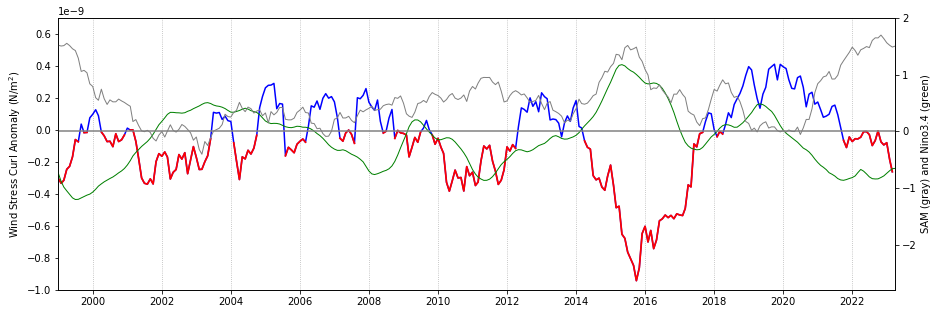

In [52]:
fig, ax1 = plt.subplots(figsize=(15,5))

window_size=25 # 25-month running mean

x = curl_tau.time
xmean = curl_tau.rolling(time=window_size,min_periods=1, center=True).mean().time

y = curl_tau.mean(['latitude','longitude']).rolling(time=window_size,min_periods=1, center=True).mean()
yanom = y - y.mean()

### Mask to make positive anomalies blue and negative anomalies red
mask_blue = ma.masked_where(yanom<0,yanom)
mask_red = ma.masked_where(yanom>0,yanom)
plt.plot(xmean, yanom, 'b', linewidth=1.5)
plt.plot(xmean, mask_red, 'r', linewidth=1.75)

ax1.set_ylabel(r'Wind Stress Curl Anomaly (N/m$^2$)', color='k')
ax1.set_ylim(-1e-9,0.7e-9)

ax2 = ax1.twinx() # Create the second plot on ax2 (twin axis)

### Anomaly with respect to 1981-2020 mean
ds_nino_mean = ds_nino.where(ds_nino.time>np.datetime64('1981-01-01'),drop=True)
ds_nino_mean = ds_nino_mean.where(ds_nino_mean.time<np.datetime64('2020-12-31'),drop=True)
nino_mean = float(ds_nino_mean.nino.mean())

lbl='Nino 3.4 7-Month Rolling Mean'
x = ds_nino.nino.rolling(time=window_size,min_periods=1,center=True).mean().time 
y = ds_nino.nino.rolling(time=window_size,min_periods=1,center=True).mean()- nino_mean
ax2.plot(x,y,color='green',linewidth=1)

x = ds_sam.sam.rolling(time=window_size,min_periods=1, center=True).mean().time
y = ds_sam.sam.rolling(time=window_size,min_periods=1, center=True).mean()# -sam_mean
ax2.plot(x,y,color='gray',linewidth=1)
ax2.set_ylabel('SAM (gray) and Nino3.4 (green)', color='k')

ax2.axhline(0,c='gray')
ax2.set_ylim(-2.8,2)
years = mdates.YearLocator()
date_format = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(mdates.YearLocator(2)) # Set the x-axis ticks to show every 2 years
ax1.xaxis.set_major_formatter(date_format)
plt.xlim(np.datetime64('1999-01-01T00:00:00.000000000'),np.datetime64('2023-04-01T00:00:00.000000000'))
ax1.grid(linestyle='dotted',axis='x')

plt.show()